In [ ]:
pip install --upgrade scikit-learn

In [9]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install numpy==1.23.0

In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, auc,
    roc_curve, recall_score, classification_report, f1_score,
    precision_recall_fscore_support,plot_confusion_matrix,
    accuracy_score, roc_auc_score,precision_score,brier_score_loss,ConfusionMatrixDisplay
)
import os
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import (
    StratifiedKFold, KFold, RepeatedKFold, GroupKFold,
    GridSearchCV, train_test_split, TimeSeriesSplit,RepeatedStratifiedKFold, cross_val_score
    
)
from sklearn import preprocessing, metrics
import gc
import warnings
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')

# Printing Kaggle input file paths
print("Kaggle input file paths:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


  **Import The Data**
  
  Import the necessary libraries for data manipulation and visualization.

In [13]:
train = pd.read_csv("/kaggle/input/widsdatathon2020/training_v2.csv")
samplesubmission = pd.read_csv("/kaggle/input/widsdatathon2020/samplesubmission.csv")
test = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")
dictionary = pd.read_csv("/kaggle/input/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("/kaggle/input/widsdatathon2020/solution_template.csv")

**Create Dictioney of the features**

Load the training data into a Pandas DataFrame and perform exploratory data analysis. Check the number of rows and columns, data types of each column, and summary statistics of the numerical variables.


In [14]:
dico=pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,encounter_id,hospital_id,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,pred
Category,identifier,identifier,identifier,demographic,demographic,demographic,demographic,demographic,demographic,demographic,...,APACHE comorbidity,APACHE comorbidity,APACHE comorbidity,APACHE comorbidity,APACHE comorbidity,APACHE comorbidity,APACHE comorbidity,APACHE grouping,APACHE grouping,GOSSIS example prediction
Unit of Measure,None,None,None,None,Years,kilograms/metres^2,None,None,None,centimetres,...,None,None,None,None,None,None,None,None,None,None
Data Type,integer,integer,integer,binary,numeric,string,binary,string,string,numeric,...,binary,binary,binary,binary,binary,binary,binary,string,string,numeric
Description,Unique identifier associated with a patient un...,Unique identifier associated with a hospital,Unique identifier associated with a patient,Whether the patient died during this hospitali...,The age of the patient on unit admission,The body mass index of the person on unit admi...,Whether the patient was admitted to the hospit...,The common national or cultural tradition whic...,The genotypical sex of the patient,The height of the person on unit admission,...,Whether the patient has a history of heavy alc...,Whether the patient has been diagnosed with di...,Whether the patient has cirrhosis and addition...,Whether the patient has their immune system su...,Whether the patient has been diagnosed with ac...,Whether the patient has been diagnosed with no...,Whether the patient has been diagnosed with an...,Admission diagnosis group for APACHE III,Admission diagnosis group for APACHE II,"Example mortality prediction, shared as a 'bas..."
Example,None,None,None,0,None,21.5,0,Caucasian,F,180,...,1,1,1,1,1,1,1,Cardiovascular,Respiratory,0.000921
count,91713,91713,91713,91713,87485,88284,91713,NaN,NaN,90379,...,90998,90998,90998,90998,90998,90998,90998,NaN,NaN,NaN
mean,65606.1,105.669,65537.1,0.0863018,62.3095,29.1858,0.183736,NaN,NaN,169.642,...,0.0156927,0.225192,0.0129893,0.0261654,0.00706609,0.00413196,0.0206378,NaN,NaN,NaN
std,37795.1,62.8544,37811.3,0.280811,16.7751,8.27514,0.387271,NaN,NaN,10.7954,...,0.124284,0.417711,0.113229,0.159628,0.083763,0.0641477,0.142169,NaN,NaN,NaN
min,1,2,1,0,16,14.8449,0,NaN,NaN,137.2,...,0,0,0,0,0,0,0,NaN,NaN,NaN
25%,32852,47,32830,0,52,23.642,0,NaN,NaN,162.5,...,0,0,0,0,0,0,0,NaN,NaN,NaN


****

## Handle Unneccesry Data
Drop columns with a single unique value

In [15]:
# Check for columns with unique values in 'train' dataframe
cols_to_drop = []
for column in train.columns:
    if train[column].nunique() == 1 or train[column].nunique() == train.shape[0]:
        cols_to_drop.append(column)

# Dropping columns with unique values
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
print(cols_to_drop)


['encounter_id', 'patient_id', 'readmission_status']


Define All Categorial Columns

In [16]:
# Check the list of categorical variables
categorical_features = train.select_dtypes(include=['object']).columns.tolist()
numeric_features  = train.columns.difference(categorical_features).tolist()
print(categorical_features)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


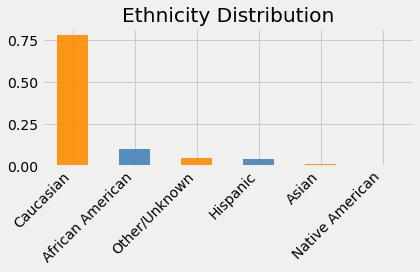

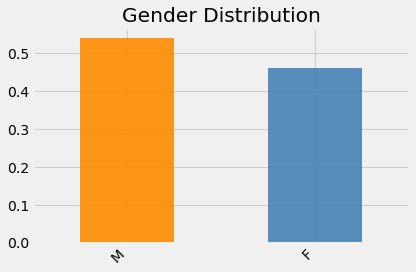

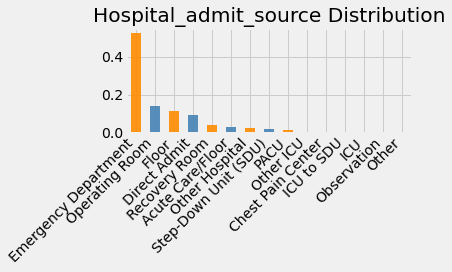

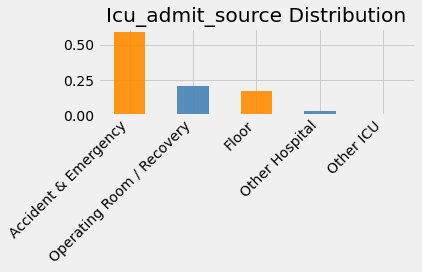

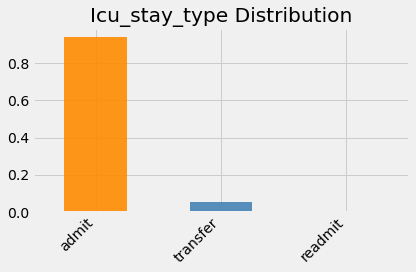

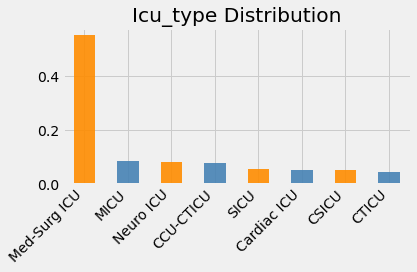

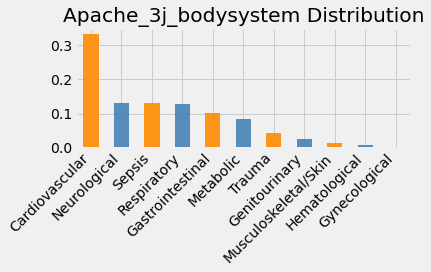

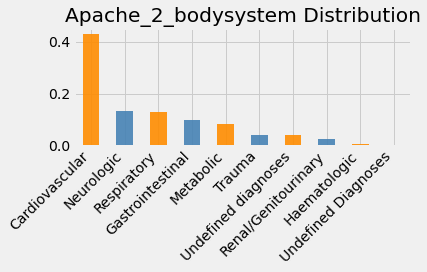

In [17]:
for feature in categorical_features:
    plt.figure(figsize=(6, 4))  # Adjust the figsize as per your preference
    train[feature].value_counts(normalize=True).plot(kind='bar', color=['darkorange', 'steelblue'], alpha=0.9)
    plt.title(f'{feature.capitalize()} Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Ensures tight spacing between subplots
    plt.show()

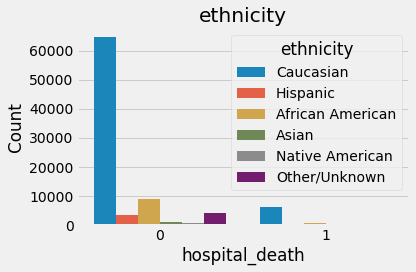

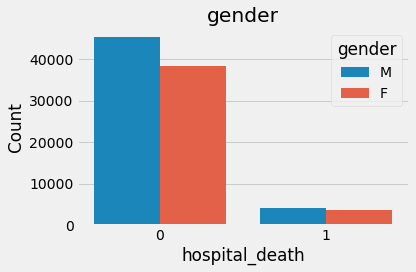

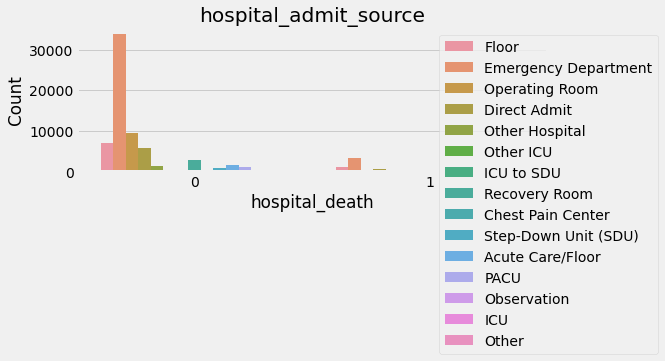

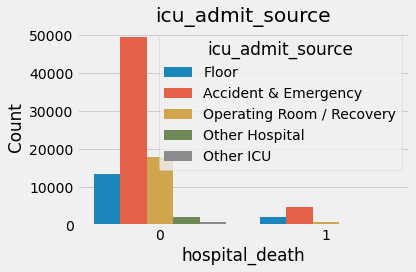

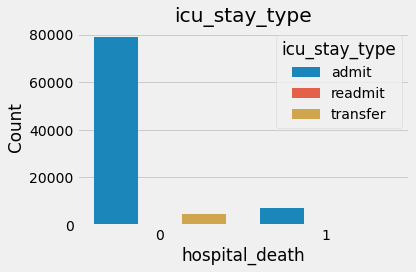

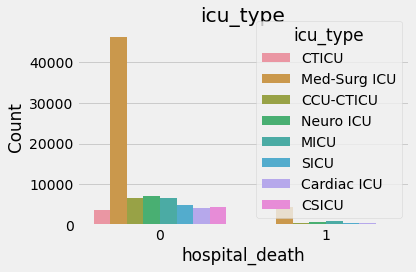

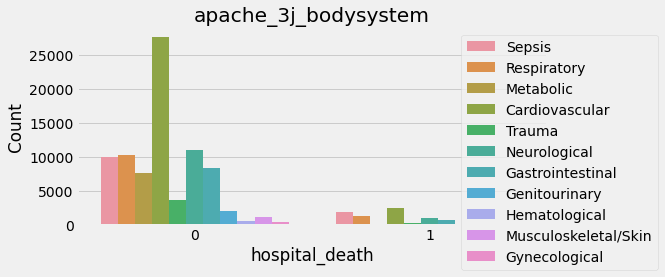

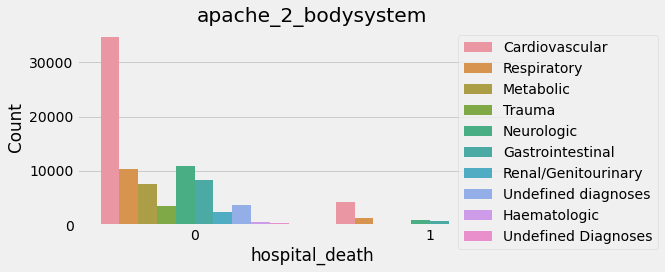

In [18]:
for feature in categorical_features:
    if train[feature].count() < 10000:
        continue
    else:
        fig, axs = plt.subplots(figsize=(10, 4)) if feature in ['apache_3j_bodysystem', 'apache_2_bodysystem', 'hospital_admit_source'] else plt.subplots(figsize=(6, 4))
        sns.countplot(x="hospital_death", hue=feature, data=train, ax=axs)
        axs.set_title(feature)
        axs.set_xlabel("hospital_death")
        axs.set_ylabel("Count")
        if feature in ['apache_3j_bodysystem', 'apache_2_bodysystem', 'hospital_admit_source']:
            axs.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
        plt.tight_layout()
        plt.show()


### Handeling missing data
We can categorize the variables into two types: categorical and numerical.
For categorical variables, missing values are replaced with the mode (most common value).
For numerical variables, missing values are replaced with the median for skewed or outlier-prone distributions, and with the mean for relatively normal distributions.

In [19]:
def missing_values_pracent(df):
    missing_values = df.isnull().sum()
    missing_percentages = (df.isnull().sum() / df.isnull().count()) * 100
    missing_df = pd.DataFrame({'Total': missing_values, 'Percent': missing_percentages}).sort_values(by='Total', ascending=False)
    missing_top_10 = missing_df.head(10)
    return missing_top_10

In [20]:
print(missing_values_pracent(train))

                      Total    Percent
h1_bilirubin_min      84619  92.265001
h1_bilirubin_max      84619  92.265001
h1_lactate_min        84369  91.992411
h1_lactate_max        84369  91.992411
h1_albumin_max        83824  91.398166
h1_albumin_min        83824  91.398166
h1_pao2fio2ratio_max  80195  87.441257
h1_pao2fio2ratio_min  80195  87.441257
h1_arterial_ph_max    76424  83.329517
h1_arterial_ph_min    76424  83.329517


In [21]:
#the code is just computing and displaying information about the missing data in the dataset,
#but it does not handle the missing data itself

#Removing columns with more than 80% missing values
missing_threshold = 80
missing_percent = (train.isnull().sum() / len(train)) * 100
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

Update df_numeric list with all the columns we have droped

In [22]:
# Remove the columns removed columns from train and test and from numeric_features and categorical_features lists
updated_numeric_features = [col for col in numeric_features if col not in cols_to_drop]
updated_categorical_features = [col for col in categorical_features if col not in cols_to_drop]
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

print("Total features dropped:", len(cols_to_drop))
print("Train Shape after dropping:", train.shape)
print("Test Shape after dropping:", test.shape)

Total features dropped: 34
Train Shape after dropping: (91713, 149)
Test Shape after dropping: (39308, 149)


In [23]:
num_cols_norm = []
num_cols_non_norm = []

for feature in updated_numeric_features:
    if '_min' in feature or '_max' in feature or 'apache' in feature:
        num_cols_norm.append(feature)
    else:
        num_cols_non_norm.append(feature)

In [24]:
#Replace all missing data in the normally distributed coulmns with the meadian
for col in num_cols_norm:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)


In [25]:
#Replace all missing data in the non-normally distributed coulmns with the average
for col in num_cols_non_norm:
    train[col].fillna(train[col].mean(), inplace=True)
    test[col].fillna(test[col].mean(), inplace=True)


Update categorial_only list with all the columns we have droped

In [26]:
# Replace categorial feature with the most common
for col in updated_categorical_features:
    train[col].fillna( train[col].mode()[0], inplace = True)
    test[col].fillna( test[col].mode()[0], inplace = True)

# **Discretisation**

In [27]:
#Create bins for BMI variable
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ['underweight', 'normal weight', 'overweight', 'obese']
train['bmi_category'] = pd.cut(train['bmi'], bins=bmi_bins, labels=bmi_labels)
test['bmi_category'] = pd.cut(test['bmi'], bins=bmi_bins, labels=bmi_labels)
print(train[['bmi', 'bmi_category']])
updated_categorical_features = updated_categorical_features + ['bmi_category']

             bmi   bmi_category
0      22.730000  normal weight
1      27.420000     overweight
2      31.950000          obese
3      22.640000  normal weight
4      29.185818     overweight
...          ...            ...
91708  23.060250  normal weight
91709  47.179671          obese
91710  27.236914     overweight
91711  23.297481  normal weight
91712  22.031250  normal weight

[91713 rows x 2 columns]


# **Data Scaling**

**Normaliztion**

In [28]:
#normalizing the age and height
scaler = MinMaxScaler()
train['age_normalized'] = scaler.fit_transform(train[['age']])
train['height_normalized'] = scaler.fit_transform(train[['height']])
test['age_normalized'] = scaler.fit_transform(test[['age']])
test['height_normalized'] = scaler.fit_transform(test[['height']])

**Categorical Encoding**

In [29]:
lencoders = {}
for col in updated_categorical_features:
    lencoders[col] = LabelEncoder()
    train[col] = lencoders[col].fit_transform(train[col])
    test[col] = lencoders[col].transform(test[col])

In [30]:
#update the updated_numeric_features list with the categorical features after enccoding them
updated_numeric_features = updated_numeric_features+ updated_categorical_features

**Standardization**

check if our data is looks Gaussian so we will know if we should Standardization

In [31]:
from scipy.stats import shapiro

stat, p = shapiro(train[updated_numeric_features])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.316, p=0.000
Sample does not look Gaussian (reject H0)


p-value may not be accurate for N > 5000.


Because we got that the information is not Geosian we will not execute Standardization

### Finding Correlation among Features

Remove the highly correlated features

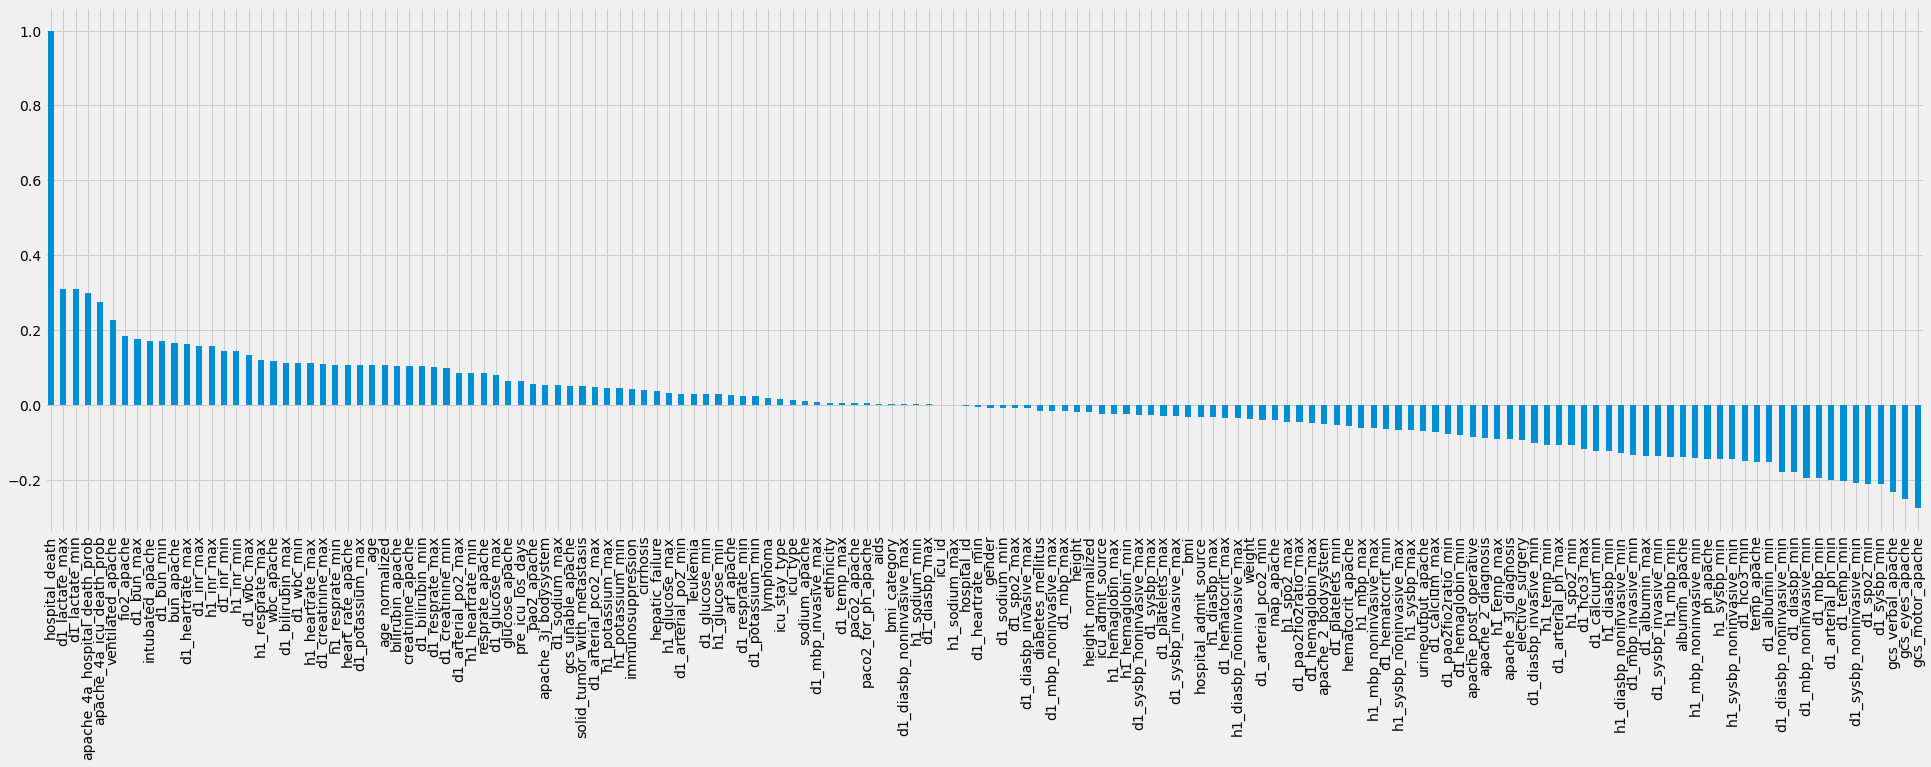

In [32]:
# get correlation of 'hospital_death' with other variables
plt.figure(figsize=(30,9))
train.corr()['hospital_death'].sort_values(ascending = False).plot(kind='bar')
plt.show()

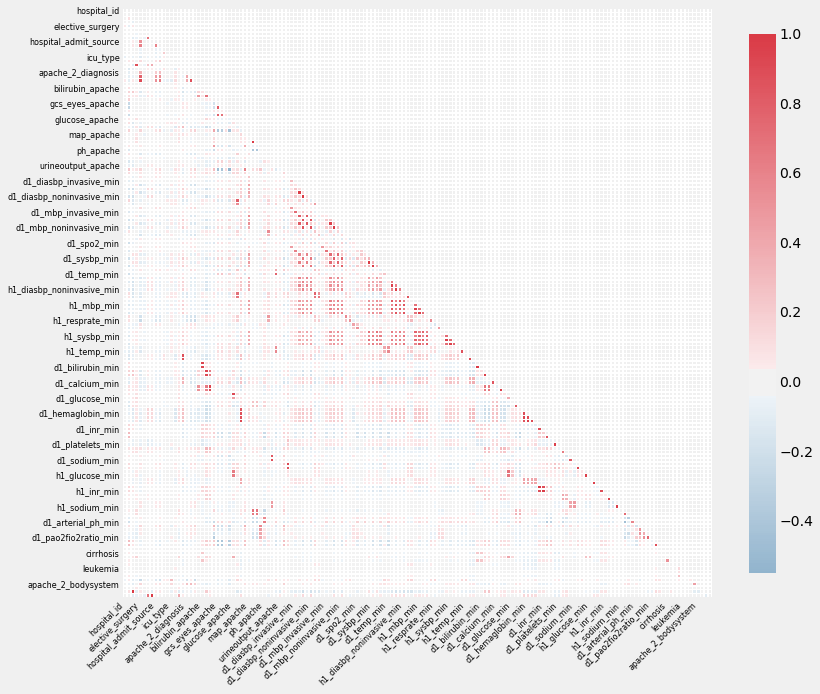

In [33]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 10))  # Adjust the figsize as per your preference
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0, square=True, annot=False, linewidths=.5, cbar_kws={"shrink": .9})
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels if needed
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()  # Adjust the spacing between the subplots
plt.show()


In [34]:
# Calculate the absolute correlation matrix
correlation_matrix = train.select_dtypes(exclude=object).corr().abs()

# Set the diagonal elements to 0
np.fill_diagonal(correlation_matrix.values, np.nan)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
upper_triangle_corr = correlation_matrix.where(mask)

upper_triangle_corr

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,bmi_category,age_normalized,height_normalized
hospital_id,NaN,0.001255,0.008472,0.012735,0.052123,0.009538,0.013650,0.027722,0.010713,0.010648,...,0.001356,0.000145,0.002980,0.002578,0.004711,0.043766,0.013572,0.009419,0.008472,0.027722
hospital_death,NaN,NaN,0.106603,0.030535,0.093574,0.005274,0.006811,0.019299,0.031352,0.022554,...,0.038660,0.043743,0.029632,0.018624,0.050837,0.054570,0.049401,0.003155,0.106603,0.019299
age,NaN,NaN,NaN,0.083680,0.066359,0.024442,0.024679,0.105900,0.039518,0.067800,...,0.019972,0.024855,0.029739,0.022959,0.025703,0.098180,0.103293,0.019673,1.000000,0.105900
bmi,NaN,NaN,NaN,NaN,0.015645,0.025439,0.041314,0.055653,0.019364,0.026632,...,0.001817,0.030365,0.013116,0.009892,0.042335,0.042777,0.006287,0.058617,0.083680,0.055653
elective_surgery,NaN,NaN,NaN,NaN,NaN,0.020595,0.029948,0.023507,0.527983,0.620941,...,0.034670,0.014682,0.017571,0.008208,0.015355,0.246577,0.149237,0.011788,0.066359,0.023507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
apache_3j_bodysystem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.444800,0.030044,0.098180,0.027862
apache_2_bodysystem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005996,0.103293,0.018687
bmi_category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019673,0.019498
age_normalized,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105900


In [35]:
# Find features with high correlation
high_cor_threshold = 0.99
high_cor_features = [col for col in upper_triangle_corr.columns if any(upper_triangle_corr[col] > high_cor_threshold)]
print("\nFeatures with high correlation:")
print(high_cor_features)
# Drop highly correlated features
train = train.drop(high_cor_features, axis=1)
test = test.drop(high_cor_features, axis=1) 
updated_numeric_features = [x for x in updated_numeric_features if x not in high_cor_features]
print("\nThe df's shape after removing highly correlated features:\n", train.shape)
print("\nThe df's shape after removing highly correlated features:\n", test.shape)


Features with high correlation:
['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_inr_max', 'h1_inr_min', 'age_normalized', 'height_normalized']

The df's shape after removing highly correlated features:
 (91713, 142)

The df's shape after removing highly correlated features:
 (39308, 142)


### Selection of top 10 features using Chi-Square

In [36]:
X_train = train.drop(['hospital_death'],axis=1)
Y_train = train['hospital_death']

In [37]:
X_train = X_train.applymap(abs)
selector = SelectKBest(chi2, k=10)
selector.fit(X_train, Y_train)
X_new = selector.transform(X_train)
print(X_train.columns[selector.get_support(indices=True)])

Index(['apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache',
       'glucose_apache', 'urineoutput_apache', 'd1_sysbp_min', 'd1_bun_max',
       'd1_bun_min', 'd1_glucose_max', 'd1_arterial_po2_max'],
      dtype='object')


In [38]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(train)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,bmi_category
0,0.574257,0.0,0.712329,0.148859,0.0,0.4,1.0,0.738140,0.285714,0.25,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9,0.000000,0.000000
1,0.391089,0.0,0.835616,0.237400,0.0,0.4,0.0,0.390478,0.285714,0.25,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8,0.666667,0.666667
2,0.574257,0.0,0.123288,0.322920,0.0,0.4,0.0,0.607981,0.214286,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,0.333333
3,0.574257,0.0,0.890411,0.147160,1.0,0.4,0.0,0.477822,0.571429,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.153465,0.0,0.041096,0.270736,0.0,0.4,1.0,0.870012,0.214286,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.777778,0.666667


## First features

In [39]:
features = ['elective_surgery', 'apache_post_operative', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_verbal_apache', 'intubated_apache',
       'ventilated_apache', 'd1_bun_max', 'd1_lactate_max', 'd1_lactate_min']

In [40]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(train)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()
X = modified_data.loc[:,modified_data.columns!='hospital_death']
y = modified_data[['hospital_death']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['elective_surgery', 'apache_post_operative', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_verbal_apache', 'intubated_apache',
       'ventilated_apache', 'd1_bun_max', 'd1_lactate_max', 'd1_lactate_min'],
      dtype='object')


In [41]:
y = y.to_numpy()

# Check the shape of y
if y.shape[1] == 1:
    y = y.ravel()

## All the functions for the training and modeling and presentation

In [42]:
def split_train_test(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [43]:
def train_models(X_train, y_train, max_iter=200):
    models = [
        ('LightGBM', GradientBoostingClassifier()),
        ('Logistic Regression', LogisticRegression(max_iter=max_iter)),
        ('Decision Tree', DecisionTreeClassifier()),
        ('Random Forest', RandomForestClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Neural Network', MLPClassifier(max_iter=max_iter))
    ]

    # Define hyperparameters for each model
    hyperparameters = {
        'LightGBM': {
            'model__learning_rate': [0.05, 0.01, 0.001],
            'model__n_estimators': [20, 50, 100]
        },
        'Logistic Regression': {
            'model__C': [0.1, 1.0, 10.0]
        },
        'Decision Tree': {
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10]
        },
        'Random Forest': {
            'model__n_estimators': [10, 50, 100],
            'model__max_depth': [5, 10, None]
        },
        'Naive Bayes': {},  # No hyperparameters for GaussianNB
        'Neural Network': {}
    }

    trained_models = {}

    # Perform 10-fold cross-validation for each model
    for model_name, model in models:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        params = hyperparameters[model_name]

        # Perform grid search with cross-validation to find the best hyperparameters
        # and evaluate the model using accuracy, precision, and recall
        start_time = time.time()
        grid_search = GridSearchCV(pipeline, params, cv=10, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        end_time = time.time()

        best_model = grid_search.best_estimator_

        # Calculate running times
        training_time = end_time - start_time

        # Perform cross-validation and calculate accuracy, precision, and recall
        start_time = time.time()
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=10)
        predicted_labels = cross_val_predict(best_model, X_train, y_train, cv=10)
        end_time = time.time()

        classification_time = end_time - start_time

        accuracy = accuracy_score(y_train, predicted_labels)
        precision = precision_score(y_train, predicted_labels)
        recall = recall_score(y_train, predicted_labels)

        # Save the trained model
        trained_models[model_name] = best_model
        joblib.dump(best_model, f'{model_name}.joblib')

    return trained_models

In [44]:
def evaluate_models(trained_models, X_train, y_train, X_test, y_test):
    results = []
    cv_scores_list = []

    # Evaluate each trained model
    for model_name, model in trained_models.items():
        # Calculate CV scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=10)
        cv_scores_list.append(cv_scores)

        # Evaluate on training set
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)

        # Evaluate on test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)

        # Append the results to the list
        results.append({
            'Model': model_name,
            'Training Accuracy': train_accuracy,
            'Training Precision': train_precision,
            'Training Recall': train_recall,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'ROC AUC': roc_auc,
            'FPR': fpr,
            'TPR': tpr
        })

    return results, cv_scores_list

In [45]:
def plot_roc_curves(trained_models, X_test, y_test):
    # Plot ROC curve for each model
    plt.figure(figsize=(10, 6))
    for model_name, model in trained_models.items():
        if model_name != 'Neural Network':
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [46]:
def plot_cv_scores(cv_scores_list):
    # Plot the CV scores
    plt.figure(figsize=(10, 6))
    plt.boxplot(cv_scores_list, labels=df_results.index)
    plt.title('Cross-Validation Scores')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

In [47]:
def plot_confusion_matrices(trained_models, X_test, y_test):
    # Display confusion matrices
    for model_name, model in trained_models.items():
        # Predict the target variable for the test set
        predictions = model.predict(X_test)

        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, predictions)

        # Display the confusion matrix with explanations
        plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Hospital Death', 'Hospital Death'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

        # Explain each cell in the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        print(f'Explanation - {model_name}:')
        print(f'True Negatives (TN): {tn} - Predicted as Not Hospital Death and Actually Not Hospital Death')
        print(f'False Positives (FP): {fp} - Predicted as Hospital Death but Actually Not Hospital Death')
        print(f'False Negatives (FN): {fn} - Predicted as Not Hospital Death but Actually Hospital Death')
        print(f'True Positives (TP): {tp} - Predicted as Hospital Death and Actually Hospital Death')


## First evaluation using only chi square for 10 features

In [48]:
# Execute the functions
X_train, X_test, y_train, y_test = split_train_test(X_new, y)
trained_models = train_models(X_train, y_train)
results, cv_scores_list = evaluate_models(trained_models,X_train,y_train, X_test, y_test)

# Create a summary table
df_results = pd.DataFrame(results)
df_results.set_index('Model', inplace=True)


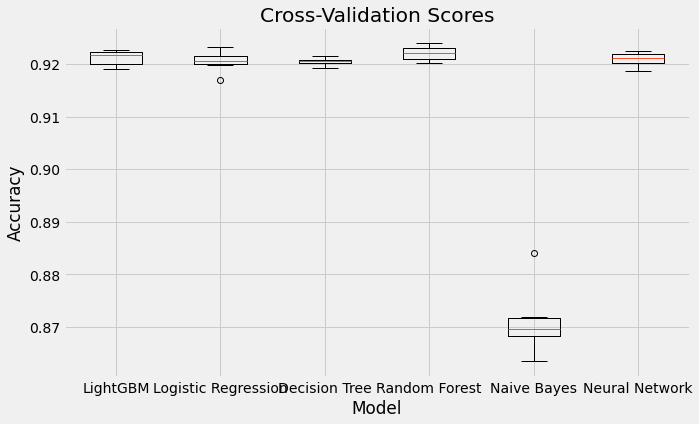

                     Training Accuracy  Training Precision  Training Recall  \
Model                                                                         
LightGBM                      0.921971            0.713074         0.159450   
Logistic Regression           0.920662            0.661362         0.164191   
Decision Tree                 0.921017            0.702047         0.146334   
Random Forest                 0.928936            0.835138         0.219343   
Naive Bayes                   0.870397            0.328035         0.479456   
Neural Network                0.922066            0.647771         0.211283   

                     Test Accuracy  Test Precision  Test Recall   ROC AUC  \
Model                                                                       
LightGBM                  0.922205        0.712766     0.168872  0.581213   
Logistic Regression       0.920842        0.658080     0.177064  0.584175   
Decision Tree             0.921550        0.722892     0.15

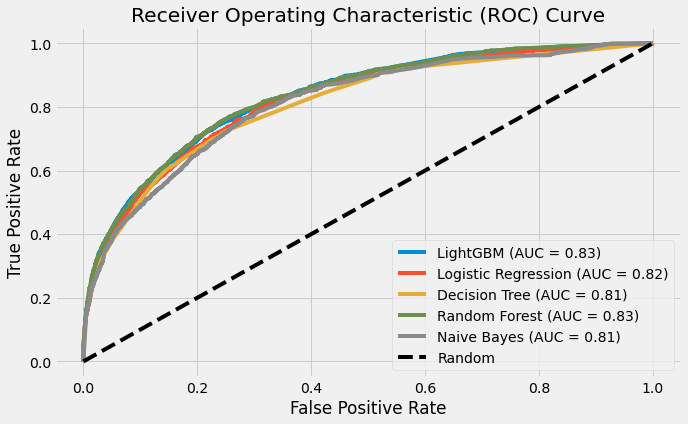

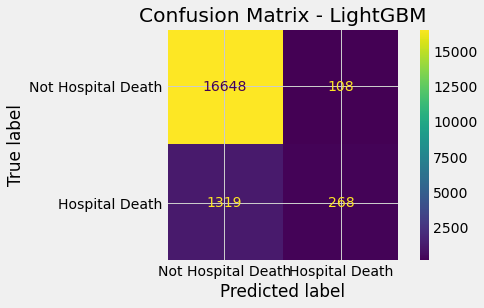

Explanation - LightGBM:
True Negatives (TN): 16648 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 108 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1319 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 268 - Predicted as Hospital Death and Actually Hospital Death


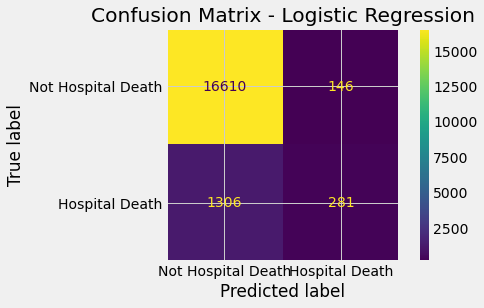

Explanation - Logistic Regression:
True Negatives (TN): 16610 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 146 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1306 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 281 - Predicted as Hospital Death and Actually Hospital Death


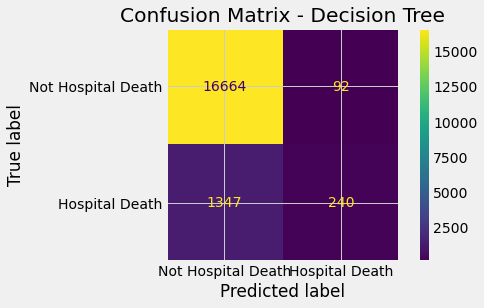

Explanation - Decision Tree:
True Negatives (TN): 16664 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 92 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1347 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 240 - Predicted as Hospital Death and Actually Hospital Death


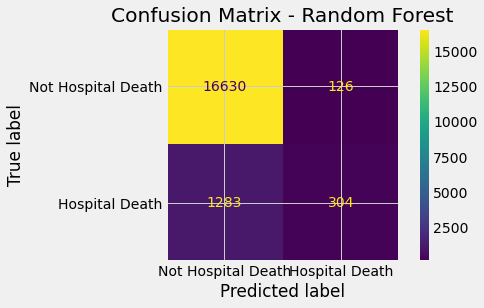

Explanation - Random Forest:
True Negatives (TN): 16630 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 126 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1283 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 304 - Predicted as Hospital Death and Actually Hospital Death


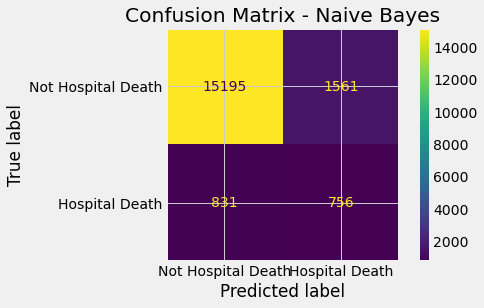

Explanation - Naive Bayes:
True Negatives (TN): 15195 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 1561 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 831 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 756 - Predicted as Hospital Death and Actually Hospital Death


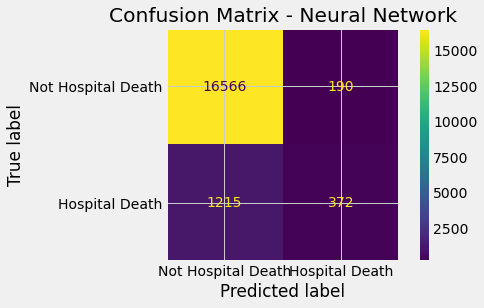

Explanation - Neural Network:
True Negatives (TN): 16566 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 190 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1215 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 372 - Predicted as Hospital Death and Actually Hospital Death


In [49]:
# Plot CV scores
plot_cv_scores(cv_scores_list)

# Display the summary table
print(df_results)

# Plot ROC curves
plot_roc_curves(trained_models, X_test, y_test)

# Display confusion matrices
plot_confusion_matrices(trained_models, X_test, y_test)

## Second evlauation using different method (with chi)

In [50]:
X = modified_data.loc[:,modified_data.columns!='hospital_death']
y = modified_data[['hospital_death']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])
y = y.to_numpy()

# Check the shape of y
if y.shape[1] == 1:
    y = y.ravel()

Index(['elective_surgery', 'apache_post_operative', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_verbal_apache', 'intubated_apache',
       'ventilated_apache', 'd1_bun_max', 'd1_lactate_max', 'd1_lactate_min'],
      dtype='object')


In [51]:
# Execute the functions
X_train, X_test, y_train, y_test = split_train_test(X_new, y)
trained_models = train_models(X_train, y_train)
results, cv_scores_list = evaluate_models(trained_models,X_train,y_train, X_test, y_test)

# Create a summary table
df_results = pd.DataFrame(results)
df_results.set_index('Model', inplace=True)

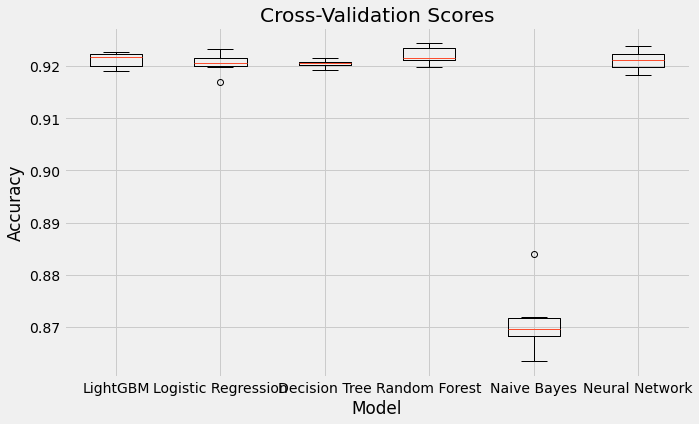

                     Training Accuracy  Training Precision  Training Recall  \
Model                                                                         
LightGBM                      0.921971            0.713074         0.159450   
Logistic Regression           0.920662            0.661362         0.164191   
Decision Tree                 0.921017            0.702047         0.146334   
Random Forest                 0.928690            0.827360         0.218869   
Naive Bayes                   0.870397            0.328035         0.479456   
Neural Network                0.921071            0.658034         0.176675   

                     Test Accuracy  Test Precision  Test Recall   ROC AUC  \
Model                                                                       
LightGBM                  0.922205        0.712766     0.168872  0.581213   
Logistic Regression       0.920842        0.658080     0.177064  0.584175   
Decision Tree             0.921550        0.722892     0.15

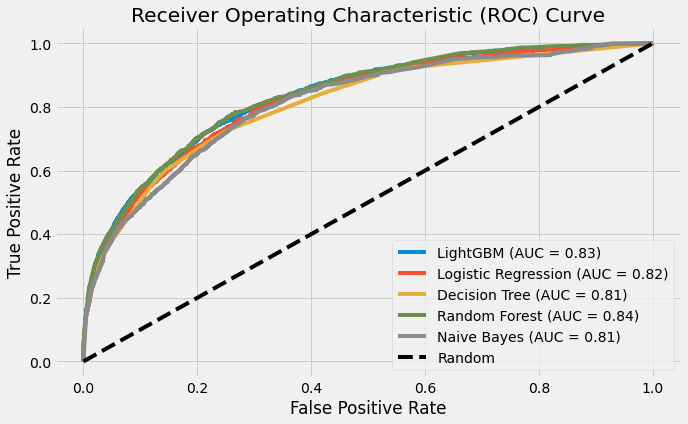

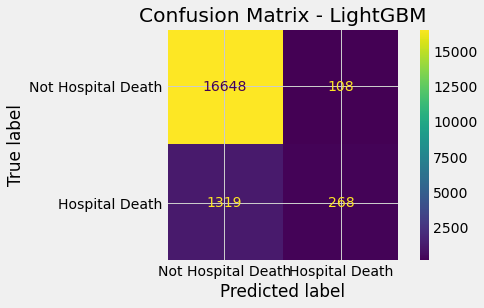

Explanation - LightGBM:
True Negatives (TN): 16648 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 108 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1319 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 268 - Predicted as Hospital Death and Actually Hospital Death


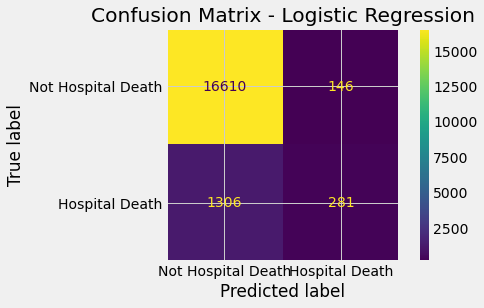

Explanation - Logistic Regression:
True Negatives (TN): 16610 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 146 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1306 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 281 - Predicted as Hospital Death and Actually Hospital Death


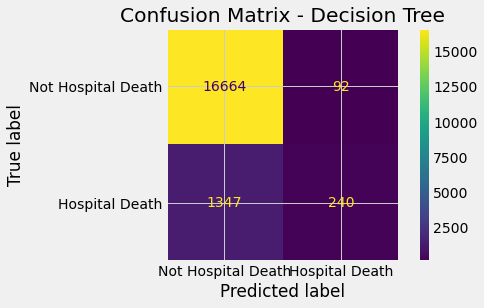

Explanation - Decision Tree:
True Negatives (TN): 16664 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 92 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1347 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 240 - Predicted as Hospital Death and Actually Hospital Death


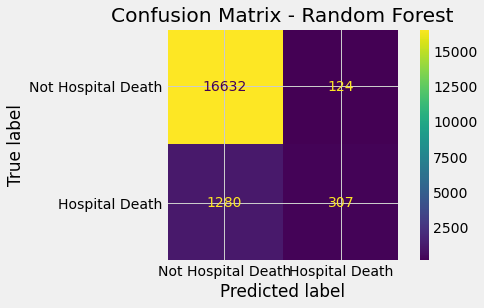

Explanation - Random Forest:
True Negatives (TN): 16632 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 124 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1280 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 307 - Predicted as Hospital Death and Actually Hospital Death


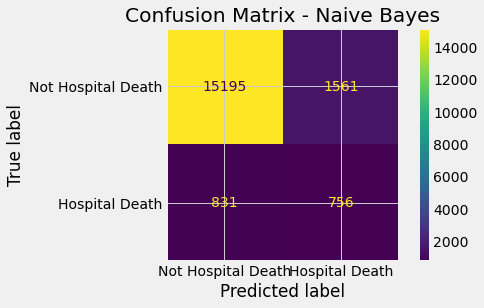

Explanation - Naive Bayes:
True Negatives (TN): 15195 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 1561 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 831 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 756 - Predicted as Hospital Death and Actually Hospital Death


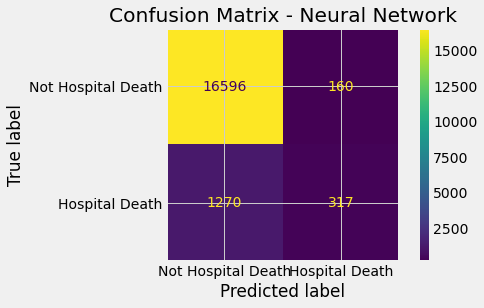

Explanation - Neural Network:
True Negatives (TN): 16596 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 160 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1270 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 317 - Predicted as Hospital Death and Actually Hospital Death


In [52]:
# Plot CV scores
plot_cv_scores(cv_scores_list)

# Display the summary table
print(df_results)

# Plot ROC curves
plot_roc_curves(trained_models, X_test, y_test)

# Display confusion matrices
plot_confusion_matrices(trained_models, X_test, y_test)

In [53]:
test = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")


## To csv

In [ ]:
# Select the specified features in the test set
X_test_selected = test[features]

# Handle missing values in the test set
X_test_selected.fillna(X_test_selected.mean(), inplace=True)  # Replace NaN values with the mean

# Scale the test data using the same scaler used during training
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_selected)

# Iterate over each model
for model_name, model in trained_models.items():
    # Load the trained model
    trained_model = joblib.load(f'{model_name}.joblib')

    # Predict the target variable for the test set
    predictions = trained_model.predict(X_test_scaled)

    # Create a DataFrame with the encounter_id and predicted hospital_death
    submission = pd.DataFrame({'encounter_id': test.encounter_id, 'hospital_death': predictions})

    # Save the predictions to a CSV file
    submission.to_csv(f'{model_name}_predictions.csv', index=False)

In [55]:
# Create a DataFrame with the encounter_id and predicted hospital_death
submission = pd.DataFrame({'encounter_id': test.encounter_id, 'hospital_death': predictions})

# Save the predictions to a CSV file
submission.to_csv('finalsub.csv', index=False)

## chi square for 40 features

In [ ]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(train)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()
X = modified_data.loc[:,modified_data.columns!='hospital_death']
y = modified_data[['hospital_death']]
selector = SelectKBest(chi2, k=40)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])
# Check the shape of y
y = y.to_numpy()

# Check the shape of y
if y.shape[1] == 1:
    y = y.ravel()

In [ ]:
# Execute the functions
X_train, X_test, y_train, y_test = split_train_test(X_new, y)
trained_models = train_models(X_train, y_train)
results, cv_scores_list = evaluate_models(trained_models,X_train,y_train, X_test, y_test)

# Create a summary table
df_results = pd.DataFrame(results)
df_results.set_index('Model', inplace=True)

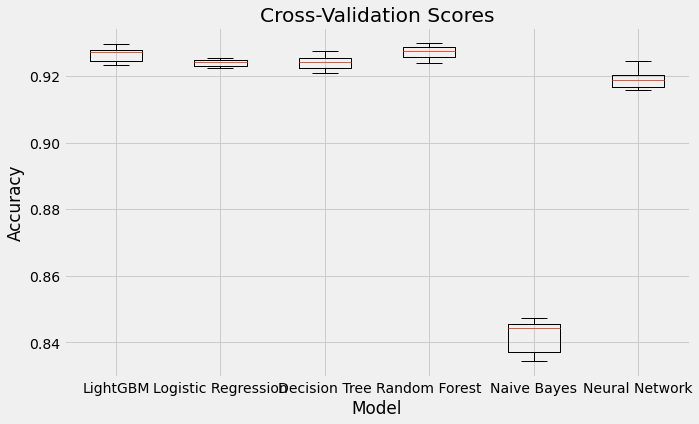

                     Training Accuracy  Training Precision  Training Recall  \
Model                                                                         
LightGBM                      0.928867            0.708224         0.298040   
Logistic Regression           0.924192            0.662840         0.246365   
Decision Tree                 0.925733            0.648731         0.302939   
Random Forest                 0.999905            1.000000         0.998894   
Naive Bayes                   0.842156            0.297197         0.608249   
Neural Network                0.941284            0.805320         0.420986   

                     Test Accuracy  Test Precision  Test Recall   ROC AUC  \
Model                                                                       
LightGBM                  0.927057        0.679137     0.297417  0.642054   
Logistic Regression       0.923840        0.662116     0.244486  0.616335   
Decision Tree             0.923350        0.617380     0.29

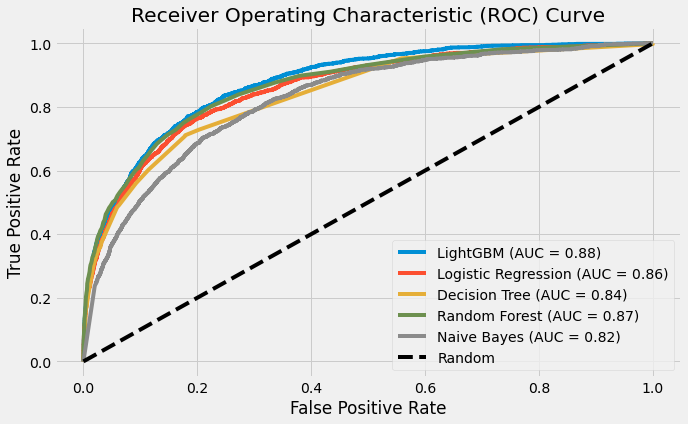

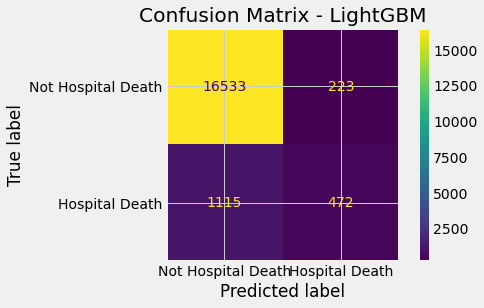

Explanation - LightGBM:
True Negatives (TN): 16533 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 223 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1115 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 472 - Predicted as Hospital Death and Actually Hospital Death


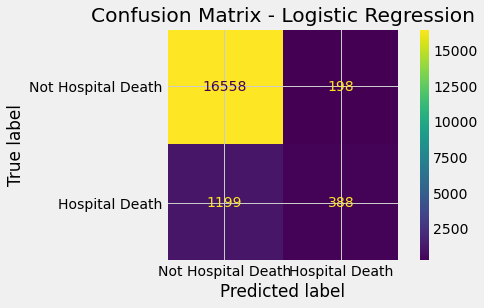

Explanation - Logistic Regression:
True Negatives (TN): 16558 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 198 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1199 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 388 - Predicted as Hospital Death and Actually Hospital Death


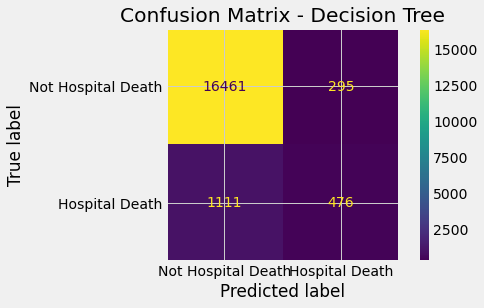

Explanation - Decision Tree:
True Negatives (TN): 16461 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 295 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1111 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 476 - Predicted as Hospital Death and Actually Hospital Death


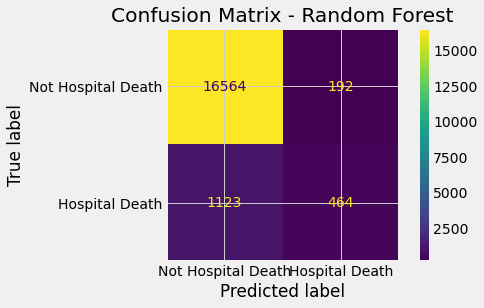

Explanation - Random Forest:
True Negatives (TN): 16564 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 192 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1123 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 464 - Predicted as Hospital Death and Actually Hospital Death


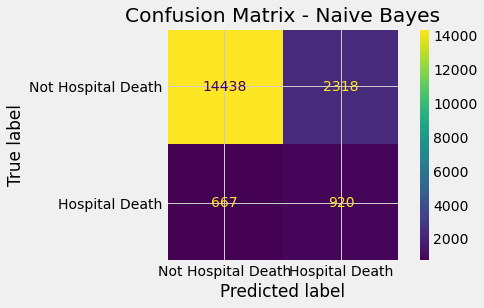

Explanation - Naive Bayes:
True Negatives (TN): 14438 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 2318 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 667 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 920 - Predicted as Hospital Death and Actually Hospital Death


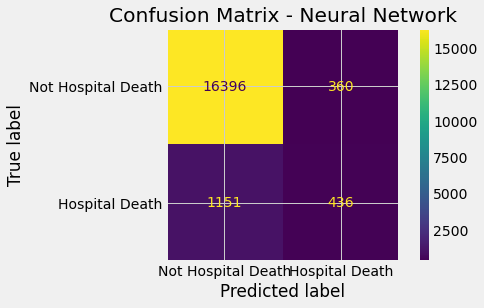

Explanation - Neural Network:
True Negatives (TN): 16396 - Predicted as Not Hospital Death and Actually Not Hospital Death
False Positives (FP): 360 - Predicted as Hospital Death but Actually Not Hospital Death
False Negatives (FN): 1151 - Predicted as Not Hospital Death but Actually Hospital Death
True Positives (TP): 436 - Predicted as Hospital Death and Actually Hospital Death


In [58]:
# Plot CV scores
plot_cv_scores(cv_scores_list)

# Display the summary table
print(df_results)

# Plot ROC curves
plot_roc_curves(trained_models, X_test, y_test)

# Display confusion matrices
plot_confusion_matrices(trained_models, X_test, y_test)

In [64]:
test = pd.read_csv("/kaggle/input/widsdatathon2020/unlabeled.csv")

In [65]:
features=['elective_surgery', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'bun_apache', 'creatinine_apache',
       'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'intubated_apache',
       'resprate_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_min',
       'd1_heartrate_max', 'd1_mbp_min', 'd1_sysbp_min', 'h1_heartrate_max',
       'h1_mbp_min', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_min', 'd1_bun_max', 'd1_bun_min',
       'd1_creatinine_max', 'd1_creatinine_min', 'd1_inr_max', 'd1_inr_min',
       'd1_lactate_max', 'd1_lactate_min', 'd1_wbc_max',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'cirrhosis', 'hepatic_failure', 'immunosuppression',
       'solid_tumor_with_metastasis']

In [ ]:
# Select the specified features in the test set
X_test_selected = test[features]

# Handle missing values in the test set
X_test_selected.fillna(X_test_selected.mean(), inplace=True)  # Replace NaN values with the mean

# Scale the test data using the same scaler used during training
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_selected)

# Iterate over each model
for model_name, model in trained_models.items():
    # Load the trained model
    trained_model = joblib.load(f'{model_name}.joblib')

    # Predict the target variable for the test set
    predictions = trained_model.predict(X_test_scaled)

    # Create a DataFrame with the encounter_id and predicted hospital_death
    submission = pd.DataFrame({'encounter_id': test.encounter_id, 'hospital_death': predictions})

    # Save the predictions to a CSV file
    submission.to_csv(f'{model_name}_predictions_chi40.csv', index=False)

## Gave each model different weight (the best so far)

In [68]:
weights = {
    'LightGBM': 0.25,
    'Logistic Regression': 0.35,
    'Decision Tree': 0.1,
    'Random Forest': 0.1,
    'Naive Bayes': 0.1,
    'Neural Network': 0.1
}

# Create an empty DataFrame to store the ensemble predictions
ensemble_predictions = pd.DataFrame({'encounter_id': test.encounter_id})

# Iterate over each model
for model_name, model in  trained_models.items():
    # Load the trained model
    trained_model = joblib.load(f'{model_name}.joblib')

    # Predict the target variable for the test set
    predictions = trained_model.predict(X_test_scaled)

    # Assign the corresponding weight to the predictions
    weight = weights[model_name]
    weighted_predictions = predictions * weight

    # Add the weighted predictions to the ensemble DataFrame
    ensemble_predictions[f'{model_name}_prediction'] = weighted_predictions

# Calculate the ensemble prediction by summing the weighted predictions
ensemble_predictions['ensemble_prediction'] = ensemble_predictions.iloc[:, 1:].sum(axis=1)

# Create a DataFrame with the encounter_id and predicted hospital_death
submission = pd.DataFrame({
    'encounter_id': ensemble_predictions['encounter_id'],
    'hospital_death': ensemble_predictions['ensemble_prediction']
})

# Save the ensemble predictions to a CSV file
submission.to_csv('ensemble_predictions.csv', index=False)